# Schoonhoven
In this notebook we build a model for the area around Schoonhoven. We mainly focus on the surface water. There are three water boards in the model area, of which we download seasonal data about the stage of the surface water. For locations without a stage from the water board, we deliniate information from a Digital Terrain Model, to set a stage. Finally, for the river Lek, we build a river package with a fixed stage of 0.0 meter.
## Import packages

In [32]:
import os
import rioxarray
import numpy as np
import pandas as pd
from rasterstats import zonal_stats
from shapely.geometry import Point
import flopy
import logging
import matplotlib
import nlmod
from nlmod.visualise.netcdf import DatasetCrossSection
import matplotlib.pyplot as plt

# set the log-level to INFO, so more information is shown (compared to the default setting of WARNING)
logging.basicConfig(level=logging.INFO)

## Model settings
We define some model settings, like the name, the directory of the model files, the model extent and the time

In [33]:
model_name = "Schoonhoven"
model_ws = os.path.join("models", model_name)
figdir, cachedir = nlmod.util.get_model_dirs(model_ws)
extent = [116500, 120000, 439000, 442000]
time = pd.date_range("2015", "2022", freq="MS") # monthly timestep

## Download data
### AHN
Download the Digital Terrain model of the Netherlands (AHN) with a resolution of 0.5 meter.

In [34]:
fname_ahn = os.path.join(cachedir, "ahn.tif")
if not os.path.isfile(fname_ahn):
    ahn = nlmod.read.ahn.get_ahn4(extent, identifier='AHN4_DTM_05m')
    ahn.rio.to_raster(fname_ahn)

### layer 'waterdeel' from bgt
As the source of the location of the surface water bodies we use the 'waterdeel' layer of the Basisregistratie Grootschalige Topografie (BGT). This data consists of detailed polygons, maintained by dutch government agencies (water boards, municipalities and Rijkswatrstaat).

In [35]:
bgt = nlmod.read.bgt.get_bgt(extent)

#### Add mimimum surface height around surface water bodies
Get the minimum surface level in 1 meter around surface water levels and add these data to the column 'ahn_min'.

In [36]:
stats = zonal_stats(bgt.geometry.buffer(1.0), fname_ahn, stats="min")
bgt["ahn_min"] = [x["min"] for x in stats]

#### Plot 'bronhouder'
We can plot the column 'bronhouder' from the GeoDataFrame bgt. We see there are three water boards in this area (with codes starting with 'W').

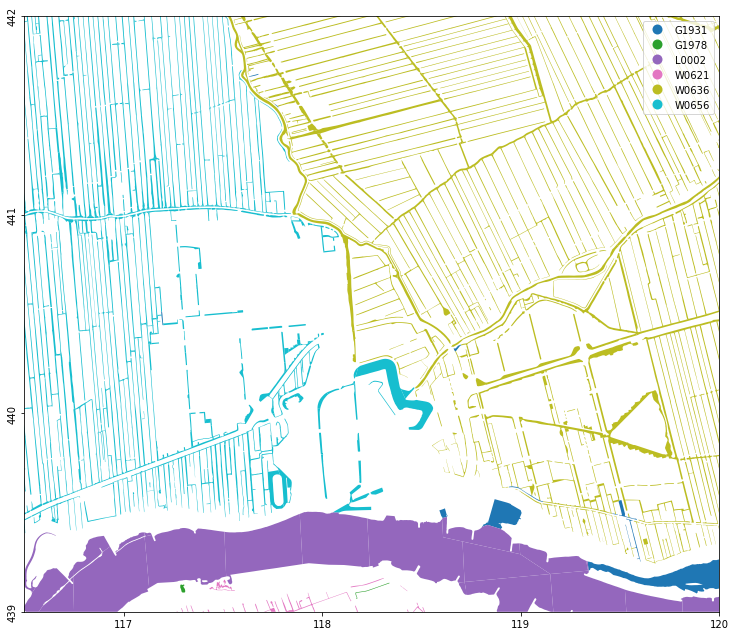

In [37]:
f, ax = nlmod.plot.get_map(extent)
bgt.plot("bronhouder", legend=True, ax=ax);

### level areas
For these three waterboards we download the level areas (peilgebieden): polygons with information about winter and summer stages.

In [38]:
pg = nlmod.gwf.surface_water.download_level_areas(bgt, extent=extent)

INFO:nlmod.gwf.surface_water:Downloading level_areas for De Stichtse Rijnlanden
INFO:nlmod.gwf.surface_water:Downloading level_areas for Rivierenland
INFO:nlmod.gwf.surface_water:Downloading level_areas for Schieland en de Krimpenerwaard


#### Plot summer stage
The method download_level_areas() generates a dictionary with the name of the water boards as keys and GeoDataFrames as values. Each GeoDataFrame contains the columns summer_stage and winter_stage. Let's plot the summer stage, together with the location of the surface water bodies.

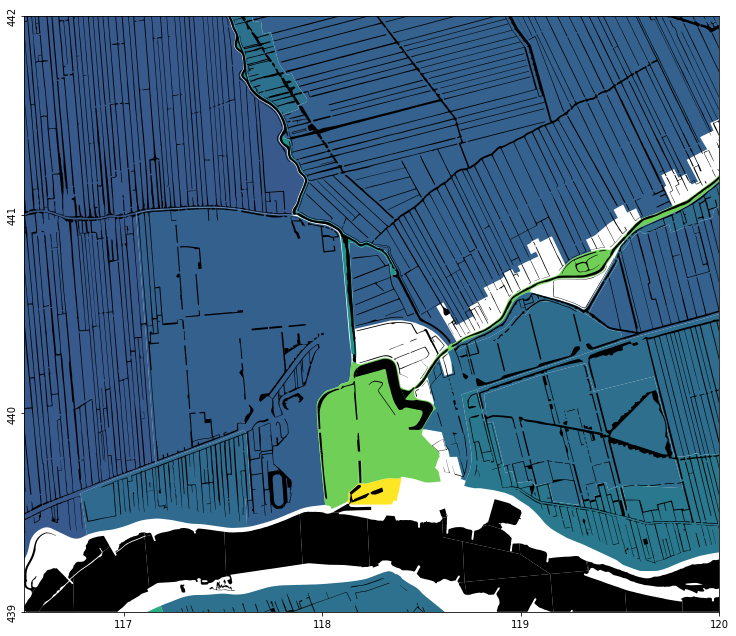

In [39]:
f, ax = nlmod.plot.get_map(extent)
bgt.plot(color="k", ax=ax)
for wb in pg:
    pg[wb].plot("summer_stage", ax=ax, vmin=-3, vmax=1, zorder=0)

#### Add stages to bgt-data
We then add the information from these level areas to the surface water bodies.

In [40]:
bgt = nlmod.gwf.surface_water.add_stages_from_waterboards(bgt, pg=pg)

c:\users\oebbe\02_python\nlmod\nlmod\gwf\surface_water.py:510: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2. Specifically: the items keyword argument will be removed.
  s = STRtree(gdf_from.geometry, items=gdf_from.index)
Adding ['summer_stage', 'winter_stage'] from level areas De Stichtse Rijnlanden to gdf: 100%|█| 521/521 [00:01<00:00, 2
c:\users\oebbe\02_python\nlmod\nlmod\gwf\surface_water.py:510: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2. Specifically: the items keyword argument will be removed.
  s = STRtree(gdf_from.geometry, items=gdf_from.index)
Adding ['summer_stage', 'winter_stage'] from level areas Rivierenland to gdf: 100%|███| 22/22 [00:00<00:00, 423.88it/s]
c:\users\oebbe\02_python\nlmod\nlmod\gwf\surface_water.py:510: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2. Specifically: the items key

#### Plot summer stage of surface water bodies
We can plot the summer stage. There are some surface water bodies without a summer-stage, because the 'bronhouder' is not a water board. The main one is the river Lek, but there are also some surface water bodies without a summer stage more north.

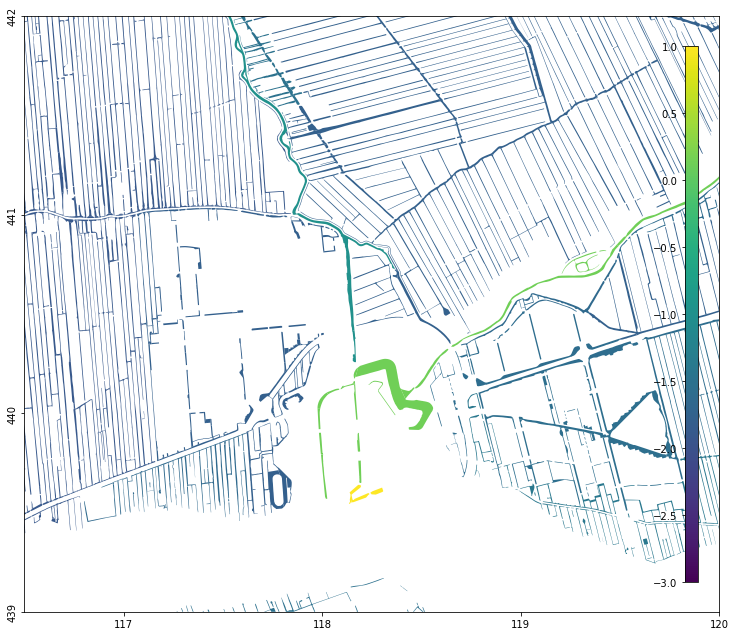

In [41]:
f, ax = nlmod.plot.get_map(extent)
norm = matplotlib.colors.Normalize(vmin=-3, vmax=1)
cmap = 'viridis'
bgt.plot("summer_stage", ax=ax, norm=norm, cmap=cmap);
nlmod.plot.colorbar_inside(norm=norm, cmap=cmap);

If no information about the stage is available, a constant stage is set to the minimal height of the digital terrain model (AHN) near the surface water body. We can plot these values as well:

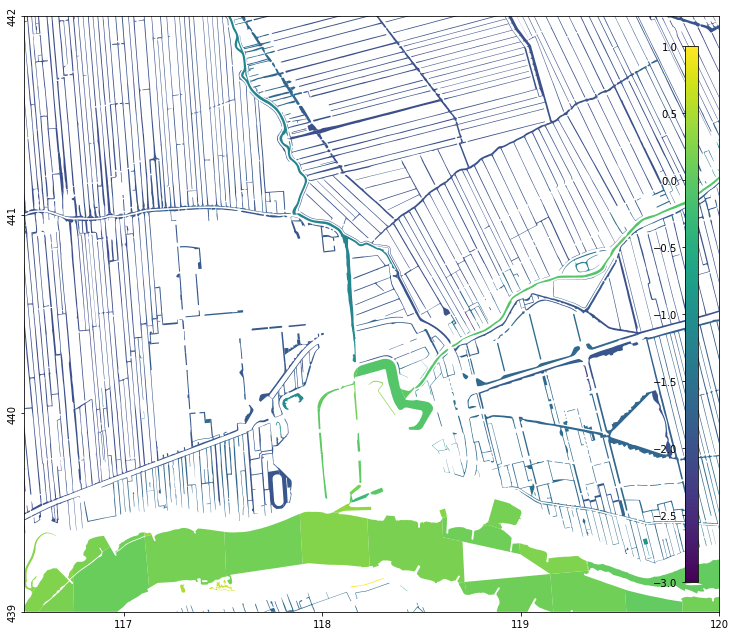

In [42]:
f, ax = nlmod.plot.get_map(extent)
bgt.plot("ahn_min", ax=ax, norm=norm, cmap=cmap)
nlmod.plot.colorbar_inside(norm=norm, cmap=cmap);

### REGIS
For the schematisation of the subsurface we use REGIS. Let's download this data for the required extent.

In [43]:
regis = nlmod.read.get_regis(extent, cachedir=cachedir, cachename="regis.nc")
regis

INFO:nlmod.cache:using cached data -> regis.nc


<xarray.Dataset>
Dimensions:  (layer: 132, y: 30, x: 35)
Coordinates:
  * x        (x) float64 1.166e+05 1.166e+05 1.168e+05 ... 1.198e+05 1.2e+05
  * y        (y) float64 4.39e+05 4.392e+05 4.392e+05 ... 4.418e+05 4.42e+05
  * layer    (layer) object 'mv' 'HLc' 'BXz1' 'BXSCk1' ... 'GUq' 'VAc' 'AKc'
Data variables:
    top      (layer, y, x) float32 ...
    botm     (layer, y, x) float32 ...
    kh       (layer, y, x) float32 ...
    kv       (layer, y, x) float32 ...
Attributes: (12/40)
    references:                    https://www.dinoloket.nl/regis-ii-het-hydr...
    Conventions:                   CF-1.7
    creator_url:                   https://www.dinoloket.nl
    keywords_vocabulary:           NASA/GCMD Earth Science Keywords. Version 6.0
    acknowledgment:                https://www.dinoloket.nl
    project:                       REGIS v02r2
    ...                            ...
    geospatial_lon_resolution:     0.0014573401
    geospatial_vertical_min:       -1235.92
    geospatial_vertical_max:       322.75
    geospatial_vertical_units:     m-NAP
    geospatial_vertical_positive:  up
    extent:                        [116500 120000 439000 442000]

We then create a regular grid, add nessecary variables (eg idomain) and fill nan's. For example, REGIS does not contain infomration about the hydraulic conductivity of the first layer ('HLc'). These NaN's are replaced by a default hydraulic conductivity (kh) of 1 m/d. This probably is not a good representation of the conductivity, but at least the model will run.

In [44]:
ds = nlmod.read.regis.to_model_ds(
    regis, model_name, model_ws, delr=100.0, delc=100.0
)
ds

INFO:nlmod.read.regis:resample regis data to structured modelgrid
INFO:nlmod.mdims.mlayers:get first active modellayer for each cell in idomain


<xarray.Dataset>
Dimensions:             (y: 30, x: 35, layer: 29)
Coordinates:
  * layer               (layer) object 'HLc' 'KRWYk1' 'KRz2' ... 'OOc' 'BRk1'
  * x                   (x) float64 1.166e+05 1.166e+05 ... 1.198e+05 1.2e+05
  * y                   (y) float64 4.42e+05 4.418e+05 ... 4.392e+05 4.39e+05
Data variables:
    top                 (y, x) float32 -1.28 -1.22 -1.25 ... -4.05 -3.76 -4.21
    botm                (layer, y, x) float32 -12.26 -12.11 ... -593.9 -595.5
    kh                  (layer, y, x) float32 1.0 1.0 1.0 1.0 ... 0.02 0.02 0.02
    kv                  (layer, y, x) float32 0.1 0.1 0.1 ... 0.002 0.002 0.002
    idomain             (layer, y, x) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    first_active_layer  (y, x) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    gridtype:                  structured
    extent:                    [116500 120000 439000 442000]
    delr:                      100.0
    delc:                      100.0
    model_name:                Schoonhoven
    mfversion:                 mf6
    model_dataset_created_on:  20220825_16:51:43
    exe_name:                  c:\users\oebbe\02_python\nlmod\nlmod\mdims\..\...
    model_ws:                  models\Schoonhoven
    figdir:                    models\Schoonhoven\figure
    cachedir:                  models\Schoonhoven\cache
    nodata:                    -999

## Add grid refinement
With the refine method, we can add grid refinement. The model will then use the disv-package instead of the dis-package. We can also test if the disv-package gives the same results as the dis-package by not specifying refinement_features: ds = nlmod.mgrid.refine(ds).

This notebook can be run with or without running the cell below.

In [45]:
refinement_features = [(bgt[bgt["bronhouder"] == "L0002"], 2)]
ds = nlmod.mgrid.refine(ds, refinement_features=refinement_features)

INFO:nlmod.mdims.mgrid:create vertex grid using gridgen
INFO:nlmod.mdims.resample:resample model layer data to vertex modelgrid
INFO:nlmod.mdims.mlayers:get first active modellayer for each cell in idomain


## Add information about time

In [46]:
ds = nlmod.mdims.set_model_ds_time(ds, time=time)

## Add knmi recharge to the model dataset

In [47]:
knmi_ds = nlmod.read.knmi.get_recharge(
    ds, cachedir=cachedir, cachename="recharge.nc"
)
ds.update(knmi_ds)

INFO:nlmod.cache:coordinate x has different values in cached dataset, not using cache
INFO:hydropandas.io.io_knmi:last RD measurement available at the Bilt is from 2022-07-20
INFO:hydropandas.io.io_knmi:assuming no RD measurements are available at other stations after this date
INFO:hydropandas.io.io_knmi:changing end_date to 2022-01-02
INFO:hydropandas.io.io_knmi:download knmi RD data from station 434-GROOT-AMMERS between 2005-01-01 00:00:00 and 2022-01-02 00:00:00
INFO:hydropandas.io.io_knmi:station 434 has 0 missing measurements
INFO:hydropandas.io.io_knmi:last RD measurement available at the Bilt is from 2022-07-20
INFO:hydropandas.io.io_knmi:assuming no RD measurements are available at other stations after this date
INFO:hydropandas.io.io_knmi:changing end_date to 2022-01-02
INFO:hydropandas.io.io_knmi:download knmi RD data from station 561-BENSCHOP between 2005-01-01 00:00:00 and 2022-01-02 00:00:00
INFO:hydropandas.io.io_knmi:station 561 has 0 missing measurements
INFO:hydropand

<xarray.Dataset>
Dimensions:             (icell2d: 2769, layer: 29, iv: 2973, nvert: 9, time: 85)
Coordinates:
  * layer               (layer) object 'HLc' 'KRWYk1' 'KRz2' ... 'OOc' 'BRk1'
    x                   (icell2d) float64 1.166e+05 1.166e+05 ... 1.2e+05
    y                   (icell2d) float64 4.42e+05 4.42e+05 ... 4.39e+05
  * time                (time) datetime64[ns] 2015-01-01 ... 2022-01-01
Dimensions without coordinates: icell2d, iv, nvert
Data variables:
    top                 (icell2d) float32 -1.28 -1.22 -1.25 ... -4.21 -4.21
    botm                (layer, icell2d) float32 -12.26 -12.11 ... -595.5 -595.5
    kh                  (layer, icell2d) float32 1.0 1.0 1.0 ... 0.02 0.02 0.02
    kv                  (layer, icell2d) float32 0.1 0.1 0.1 ... 0.002 0.002
    idomain             (layer, icell2d) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    first_active_layer  (icell2d) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    area                (icell2d) float32 1e+04 1e+04 1e+04 ... 625.0 625.0
    xv                  (iv) float64 1.165e+05 1.166e+05 ... 1.2e+05 1.2e+05
    yv                  (iv) float64 4.42e+05 4.42e+05 ... 4.39e+05 4.39e+05
    icvert              (icell2d, nvert) int32 0 1 2 3 0 -1 ... 2969 -1 -1 -1 -1
    recharge            (icell2d, time) float64 0.003719 0.001629 ... -0.0002
Attributes:
    gridtype:                  vertex
    extent:                    [116500 120000 439000 442000]
    delr:                      100.0
    delc:                      100.0
    model_name:                Schoonhoven
    mfversion:                 mf6
    model_dataset_created_on:  20220825_16:51:43
    exe_name:                  c:\users\oebbe\02_python\nlmod\nlmod\mdims\..\...
    model_ws:                  models\Schoonhoven
    figdir:                    models\Schoonhoven\figure
    cachedir:                  models\Schoonhoven\cache
    nodata:                    -999

## Create a groundwater flow model
Using the data from the xarray Dataset ds we generate a groundwater flow model.

In [51]:
# create simulation 
sim = nlmod.gwf.sim_from_model_ds(ds)

# create time discretisation
tdis = nlmod.gwf.tdis_from_model_ds(ds, sim)

# create groundwater flow model
gwf = nlmod.gwf.gwf_from_model_ds(ds, sim)

# create ims
ims = nlmod.gwf.ims_to_sim(sim)

# Create discretization
nlmod.gwf.dis_from_model_ds(ds, gwf)

# create node property flow
nlmod.gwf.npf_from_model_ds(ds, gwf, save_flows=True)

# Create the initial conditions package
nlmod.gwf.ic_from_model_ds(ds, gwf, starting_head=0.0)

# Create the output control package
nlmod.gwf.oc_from_model_ds(ds, gwf)

# create recharge package
rch = nlmod.gwf.rch_from_model_ds(ds, gwf)

# create storagee package
sto = nlmod.gwf.sto_from_model_ds(ds, gwf)

INFO:nlmod.gwf.sim:creating modflow SIM
INFO:nlmod.gwf.sim:creating modflow SIM, TDIS, GWF and IMS
INFO:nlmod.gwf.gwf:creating modflow GWF
INFO:nlmod.gwf.gwf:creating modflow IMS
Building ts packages rch: 100%|█████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 111.40it/s]


## Process surface water
We cut the surface water bodies with the grid, set a default resistance of 1 day, and seperate the large river 'Lek' form the other surface water bodies.

In [52]:
mg = nlmod.mgrid.modelgrid_from_model_ds(ds)
gi = flopy.utils.GridIntersect(mg, method="vertex")
bgt_grid = nlmod.mdims.gdf2grid(bgt, ix=gi).set_index("cellid")
bgt_grid["cond"] = bgt_grid.area / 1.0
mask = bgt_grid["bronhouder"] == "L0002"
lek = bgt_grid[mask]
bgt_grid = bgt_grid[~mask]

C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\flopy\utils\gridintersect.py:138: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  self.strtree = STRtree(self._get_gridshapes())
C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\flopy\utils\gridintersect.py:293: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = icell
Intersecting with grid:   0%|                                                                 | 0/1456 [00:00<?, ?it/s]C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\numpy\core\records.py:506: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return self.setfield(val, *res)
Intersecting with grid:   3%|█▋                                     

### Lek as river
Model the river Lek as a river with a fixed stage of 0.5 m NAP

In [53]:
lek["stage"] = 0.0
lek["rbot"] = -3.0
spd = nlmod.gwf.surface_water.build_spd(lek, "RIV", ds)
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data={0: spd})

Building stress period data RIV: 100%|███████████████████████████████████████████| 1702/1702 [00:00<00:00, 5837.42it/s]


### Other surface water as drains
model the other surface water using the drain package, with a summer stage and a  winter stage

In [54]:
nlmod.gwf.surface_water.gdf_to_seasonal_pkg(bgt_grid, gwf, ds);

Building stress period data DRN: 100%|███████████████████████████████████████████| 4166/4166 [00:00<00:00, 5888.10it/s]


## Run the model

In [55]:
nlmod.gwf.write_and_run_model(gwf, ds)

INFO:nlmod.gwf.gwf:write model dataset to cache
INFO:nlmod.gwf.gwf:write modflow files to model workspace


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model Schoonhoven...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package rch...
    writing package ts_0...
    writing package ts_1...
    writing package sto...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 1702 based on size of stress_period_data
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 8332 based on size of stress_period_data


INFO:nlmod.gwf.gwf:run model


    writing package obs_0...
    writing package ts_2...
FloPy is using the following  executable to run the model: c:\users\oebbe\02_python\nlmod\nlmod\gwf\..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/04/2022

   MODFLOW 6 compiled Mar 07 2022 16:14:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furtherm

## Post-processing
### Get the simulated head

In [56]:
head = nlmod.util.get_heads_dataarray(ds)

### Plot the average head in the first layer on a map

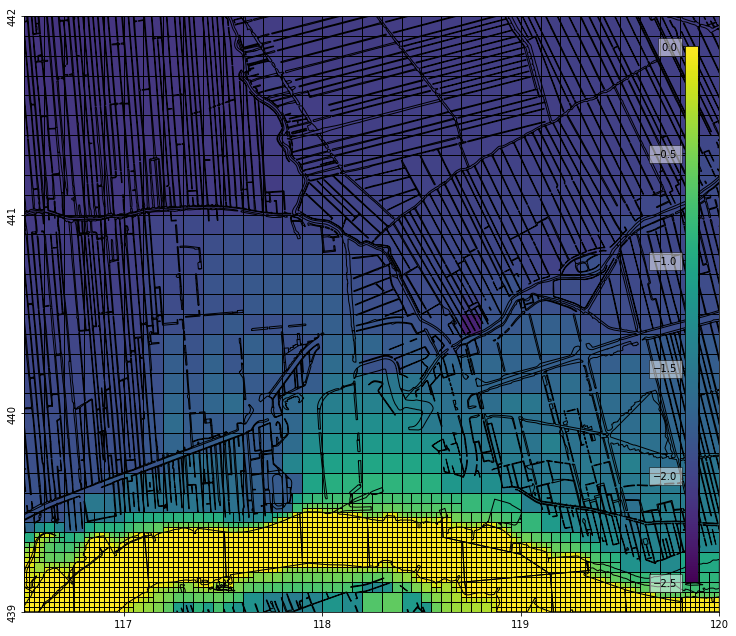

In [57]:
f, ax = nlmod.plot.get_map(extent)
norm = matplotlib.colors.Normalize(-2.5, 0.0)
pc = nlmod.plot.da(head.sel(layer="HLc").mean("time"), ds=ds, edgecolor="k", norm=norm)
cbar = nlmod.plot.colorbar_inside(pc)
for label in cbar.ax.yaxis.get_ticklabels():
    label.set_bbox(dict(facecolor='w', alpha=0.5))
bgt.plot(ax=ax, edgecolor="k", facecolor="none");

### Plot the average head in a cross-section, from north to south

c:\users\oebbe\02_python\nlmod\nlmod\visualise\netcdf.py:52: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(polygons)
INFO:shapely.geos:Ring Self-intersection at or near point 100 -11.829999923706055
INFO:shapely.geos:Self-intersection at or near point 100 -22.790000915527344
c:\users\oebbe\02_python\nlmod\nlmod\visualise\netcdf.py:197: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pol in pols:
INFO:shapely.geos:Self-intersection at or near point 3000 -50.430000305175781
INFO:shapely.geos:Self-intersection at or near point 3000 -50.430000305175781


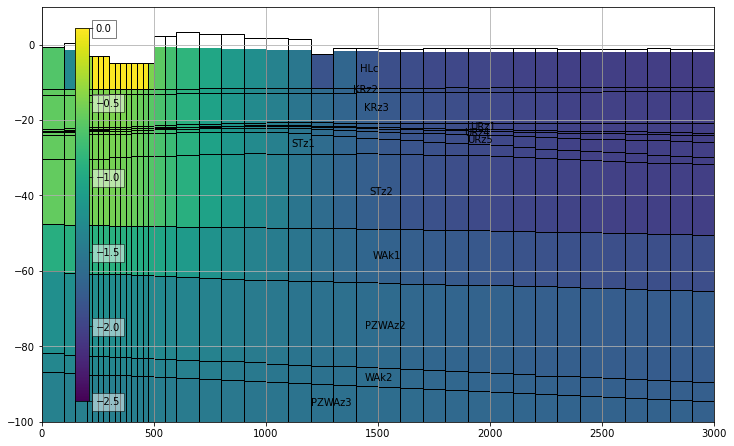

In [90]:
x = 118228.
line = [(x, 439000), (x, 442000)]
f, ax = plt.subplots(figsize=(10, 6))
ax.grid()
dcs = DatasetCrossSection(ds, line, ax=ax, zmin=-100., zmax=10.)
pc = dcs.plot_array(head.mean("time"), norm=norm, head=head.mean("time"))
# add labels with layer names
cbar = nlmod.plot.colorbar_inside(pc, bounds=[0.05, 0.05, 0.02, 0.9])
for label in cbar.ax.yaxis.get_ticklabels():
    label.set_bbox(dict(facecolor='w', alpha=0.5))
dcs.plot_grid()
dcs.plot_layers(alpha=0.0, min_label_area=1000)
f.tight_layout(pad=0.0)

### plot a time series at a certain location

C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\flopy\utils\gridintersect.py:468: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  rec.ixshapes = isectshp


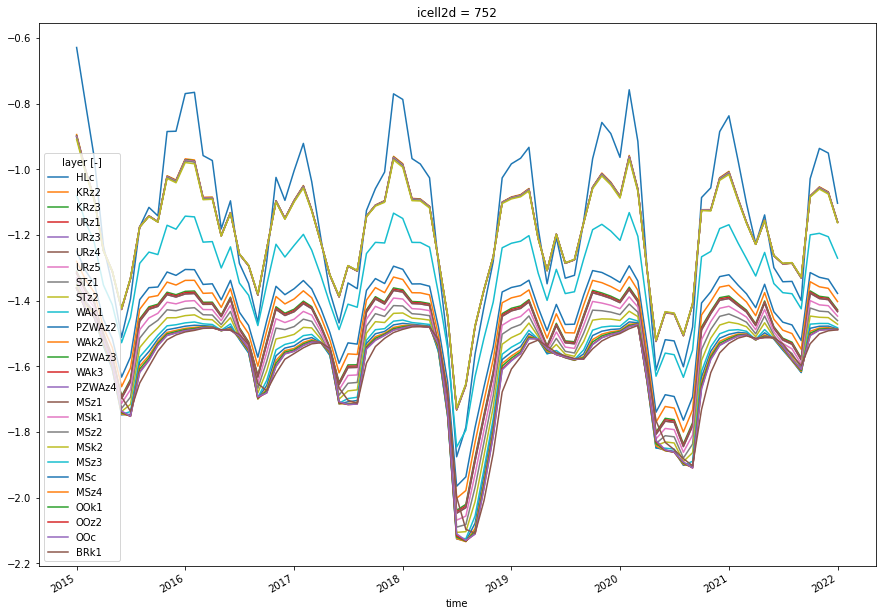

In [59]:
x = 118228
y = 439870
if ds.gridtype == "vertex":
    icelld2 = gi.intersect(Point(x, y))["cellids"][0]
    head_point = head[:, :, icelld2]
else:
    head_point = head.interp(x=x, y=y, method="nearest")
# only keep layers that are active at this location
head_point = head_point[:, ~head_point.isnull().all('time')]
head_point.plot.line(hue="layer", size=(10));

### Plot some properties of the first layer
We can plot some properties of the first layer, called HLc. As REGIS does not contain data about hydraulic conductivities for this layer, default values of 1 m/d for kh and 0.1 m/d for hv are used, which can be seen in the graphs below.

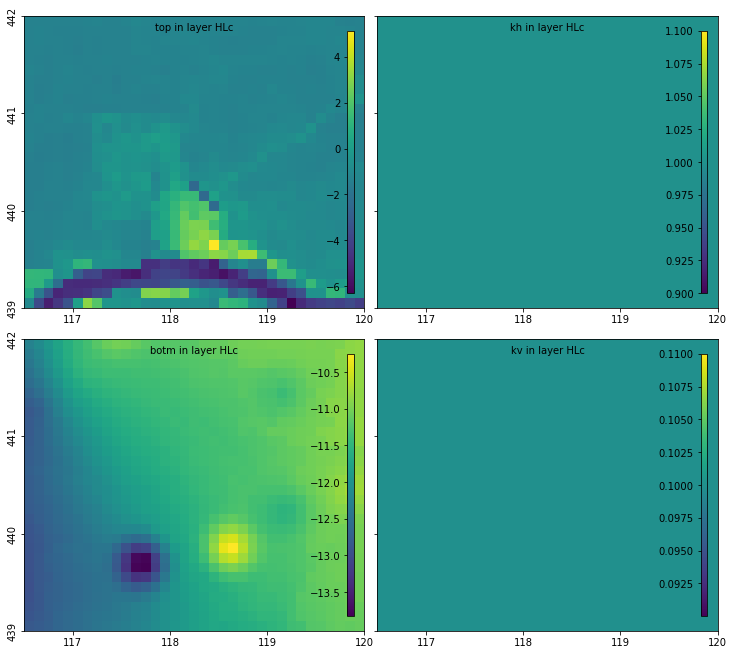

In [60]:
layer = "HLc"
f, axes = nlmod.plot.get_map(extent, nrows=2, ncols=2)
variables = ['top', 'kh', 'botm','kv']
for i, variable in enumerate(variables):
    ax = axes.ravel()[i]
    if variable == 'top':
        if layer == ds.layer[0]:
            da = ds['top']
        else:
            da = ds['botm'][np.where(ds.layer == layer)[0][0]-1]
    else:
        da = ds[variable].sel(layer=layer)
    pc = nlmod.plot.da(da, ds=ds, ax=ax)
    nlmod.plot.colorbar_inside(pc, ax=ax)
    ax.text(0.5, 0.98, f'{variable} in layer {layer}', ha='center', va='top', transform=ax.transAxes)

## Add pathlines

We create a modpath model which calculates the pathlines. We calculate the pathlines that start in the center of the modflow cells with a river boundary condition (the cells in the "Lek" river).

In [78]:
# create a modpath model
mpf = nlmod.modpath.mpf(gwf)

# create the basic modpath package
_mpfbas = nlmod.modpath.bas(mpf)

# get the nodes from a package
nodes = nlmod.modpath.package_to_nodes(gwf, 'RIV_0', mpf)

# create a particle tracking group from cell centers
pg = nlmod.modpath.pg_from_pd(nodes, localx=0.5, localy=0.5, localz=0.5)

# create the modpath simulation file
mpsim = nlmod.modpath.sim(mpf, pg, 'forward', gwf=gwf)

adding Package:  MPBAS
adding Package:  MPSIM


In [79]:
# run modpath model
nlmod.modpath.write_and_run_model(mpf, nb_path='10_modpath.ipynb')

INFO:nlmod.modpath.modpath:removed 'mp7_Schoonhoven_f.mppth'
INFO:nlmod.modpath.modpath:removed 'mp7_Schoonhoven_f.timeseries'
INFO:nlmod.modpath.modpath:removed 'mp7_Schoonhoven_f.mpend'
INFO:nlmod.modpath.modpath:write script 2022082510_modpath.ipynb to modpath workspace
INFO:nlmod.modpath.modpath:write modpath files to model workspace
INFO:nlmod.modpath.modpath:run modpath model



Writing packages:
   Package:  MPBAS
   Package:  MPSIM
 
FloPy is using the following  executable to run the model: c:\users\oebbe\02_python\nlmod\nlmod\modpath\..\bin\mp7.exe

MODPATH Version 7.2.002 PROVISIONAL 
Program compiled Nov 23 2021 09:33:21 with IFORT compiler (ver. 19.0.5)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  3.65200E+03  Steady-state flow                                                    
Processing Time Step     1 Period     2.  Time =  3.68300E+03  Steady-state flow                                                    
Processing Time Step     1 Period     3.  Time =  3.71100E+03  Steady-state flow                                                    
Processing Time Step     1 Period     4.  Time =  3.74200E+03  Steady-state flow                                                    
Processing Time Step     1 Period     5.  Time =  3.77200E+03  Steady-state flow                                                  

In [80]:
pdata = nlmod.modpath.load_pathline_data(mpf)

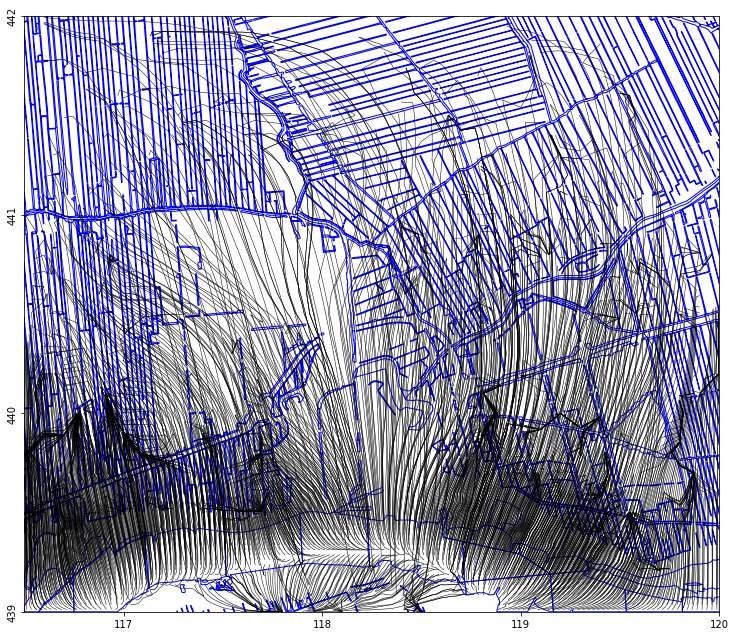

In [85]:
f, ax = nlmod.plot.get_map(extent)
    
for pid in np.unique(pdata['particleid']):
    pf = pdata[pdata['particleid']==pid]
    ax.plot(pf['x'],pf['y'], color="k", linewidth=0.5)
ax.plot(pf['x'],pf['y'], color="k", linewidth=0.5, label='pathline')
bgt.plot(ax=ax, edgecolor="blue", facecolor="none");


c:\users\oebbe\02_python\nlmod\nlmod\visualise\netcdf.py:52: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(polygons)
INFO:shapely.geos:Ring Self-intersection at or near point 100 -11.829999923706055
INFO:shapely.geos:Self-intersection at or near point 100 -22.790000915527344
c:\users\oebbe\02_python\nlmod\nlmod\visualise\netcdf.py:197: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pol in pols:
INFO:shapely.geos:Self-intersection at or near point 3000 -50.430000305175781
INFO:shapely.geos:Self-intersection at or near point 3000 -50.430000305175781


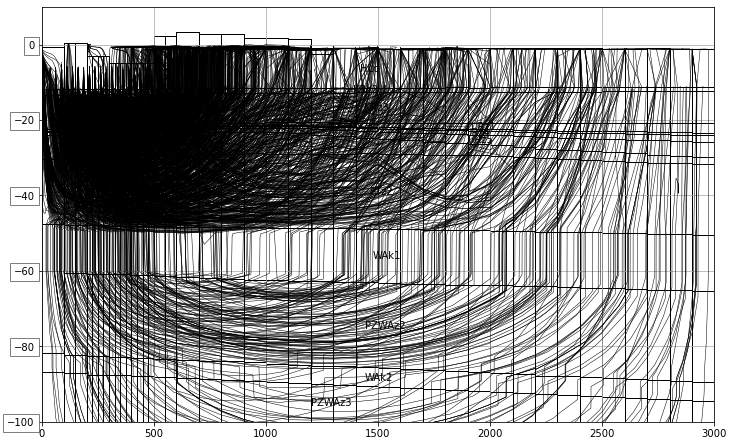

In [94]:
x = 118228.
line = [(x, 439000), (x, 442000)]
f, ax = plt.subplots(figsize=(10, 6))
ax.grid()
dcs = DatasetCrossSection(ds, line, ax=ax, zmin=-100., zmax=10.)

# add labels with layer names
for label in ax.yaxis.get_ticklabels():
    label.set_bbox(dict(facecolor='w', alpha=0.5))
    
for pid in np.unique(pdata['particleid']):
    pf = pdata[pdata['particleid']==pid]
    ax.plot(pf['y']- extent[2],pf['z'], color="k", linewidth=0.5)
    
dcs.plot_grid()
dcs.plot_layers(alpha=0.0, min_label_area=1000)
f.tight_layout(pad=0.0)